# **Hypothesis Testing With Insurance Data**

## *Jaco van Wyk*

--------------

Q1. Do smokers have higher insurance charges than non-smokers?

Q2. Are men more likely to smoke than women?

Q3. Do different regions have different charges, on average?




- State your Null Hypothesis and Alternative Hypothesis
- Select the correct test according to the data type and number of samples
- Test the assumptions of your selected test.
- Execute the selected test, or the alternative test (if you do not meet the assumptions)
- Interpret your p-value and reject or fail to reject your null hypothesis 
- Show a supporting visualization that helps display the result

In [1]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [35]:
# Data

file = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vQBN8DPW2rdiRrY34eEM53HAzakNGSRrw4ogI-j8HyCUrbqTB_z4CeIn2IvjLF-w_6sOe5pIlypJGAA/pub?output=csv'
df = pd.read_csv(file)

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [37]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### **Q1. Do smokers have higher insurance charges than non-smokers?**

#### Hypotheses

H<sub>0</sub>: Smokers and non-smokers have the same insurance charges, $\mu_{smokers} = \mu_{non-smokers}$

H<sub>1</sub>: Smokers have higher insurance charges than non-smokers, $\mu_{smokers} > \mu_{non-smokers}$

#### Test: **Two-sample t-test**

Assumptions:

- No significant outliers
- Normality
- Equal variance

In [38]:
# Investigate smoking status numbers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [39]:
# Split data into separate groups for smokers and non-smokers
smoker_df = df.loc[df['smoker'] == 'yes'].copy()
nonsmoker_df = df.loc[df['smoker'] == 'no'].copy()


#### Remove outliers and test t-test assumptions

In [41]:
# Check for smoker outliers
zscores= stats.zscore(smoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)


0

In [42]:
# Check for non-smoker outliers
zscores= stats.zscore(nonsmoker_charge)
outliers = abs(zscores)>3
np.sum(outliers)


24

In [43]:
# Remove non-smoker outliers
nonsmoker_charge = nonsmoker_charge[(np.abs(stats.zscore(nonsmoker_charge)) < 3)]


In [64]:
# test smoker group for normality
result_smoker_charge = stats.normaltest(smoker_charge)
result_smoker_charge


NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

Not normally distributed at 0.05 level of significance, but the number of data points is high enough (n = 274) to assume normality of sample means (central limit theorem)

In [45]:
# Test non-smoker group for normality
result_nonsmoker_charge = stats.normaltest(nonsmoker_charge)
result_nonsmoker_charge


NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

Not normally distributed at 0.05 level of significance, but the number of data points is high enough (n = 1040 after removing outliers) to assume normality of sample means (central limit theorem)

In [46]:
# Test for equal variance
result = stats.levene(smoker_charge, nonsmoker_charge)
result


LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

Unequal variances &rarr; set equal_var = False when performing t-test

#### Perform t-test

In [47]:
# Independent t-test with equal_var set to False
result = stats.ttest_ind(smoker_charge, nonsmoker_charge, equal_var = False)
result


TtestResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104, df=301.26189518807416)

#### Interpretation

The p-value of $2.5753\times10^{-104}$ is lower than the set rejection threshold ($\alpha$) of $0.05$<br>
Reject the null hypotheses and conclude, with 95% confidence, that smokers have higher charges than non-smokers

#### Visualisation

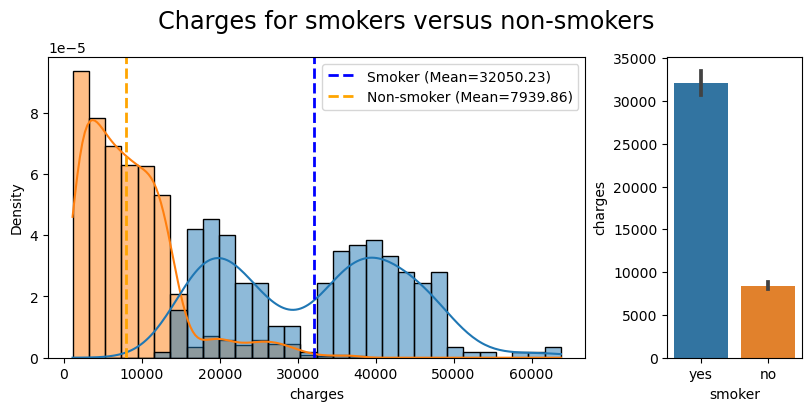

In [54]:
## Visualizing means
fig, (ax,ax_bar) = plt.subplots(figsize= (8,4), ncols=2,
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='smoker',kde=True,
                  stat='density',common_norm=False,ax=ax)

ax.axvline(np.mean(smoker_charge), ls='--',lw=2,
           label=f"Smoker (Mean={np.mean(smoker_charge):.2f})",color='blue')

ax.axvline(np.mean(nonsmoker_charge), ls='--', lw=2,
           label=f"Non-smoker (Mean={np.mean(nonsmoker_charge):.2f})",color='orange')

ax.legend(prop={"size":10}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='smoker',y='charges',ax = ax_bar)
fig.suptitle('Charges for smokers versus non-smokers',fontsize='xx-large');

### **Q2. Are men more likely to smoke than women?**

#### Hypotheses

H<sub>0</sub>: There is no relationship between sex and smoking status

H<sub>1</sub>: There is a relationship between sex and smoking status

#### Test: **$\chi^{2}$ test for independence**

Assumptions:

- There are two categorical variables
- Each of the two variables consist of (two or more) *independent* categorical groups

In [55]:
# Investigate smoking status numbers
df['sex'].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [56]:
# Investigate smoking status numbers
df['smoker'].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

#### Test $\chi^{2}$ test assumptions

There are two categorical variables: 'sex' and 'smoker'

The groups for 'sex' are indpendent from each other: one data point's value being male does not play role in any other data point's category value

The groups for 'smoker' are indpendent from each other: one data point's value being yes does not play role in any other data point's value (assuming data points don't come from groups where, for example, peer pressure from one data point could have influenced the smoking status of another data point, or something similar)

The assumptions underlying the $\chi^{2}$ test are valid

In [58]:
# calculate the contingency table with pd.cross-tab
table = pd.crosstab(df['sex'], df['smoker'])
table


smoker,no,yes
sex,,
female,547,115
male,517,159


#### Perform t-test

In [59]:
# Perform chi-square test
result = stats.chi2_contingency(table)
chi2, p, deg_free, expected_vals = result

print(p)
p<.05


0.006548143503580696


True

#### Interpretation

The p-value of $0.0065481$ is lower than the set required rejection threshold ($\alpha$) of $0.05$<br>
Reject the null hypotheses and conclude, with 95% confidence, that there is a relationship between smoking status and sex

#### Visualisation

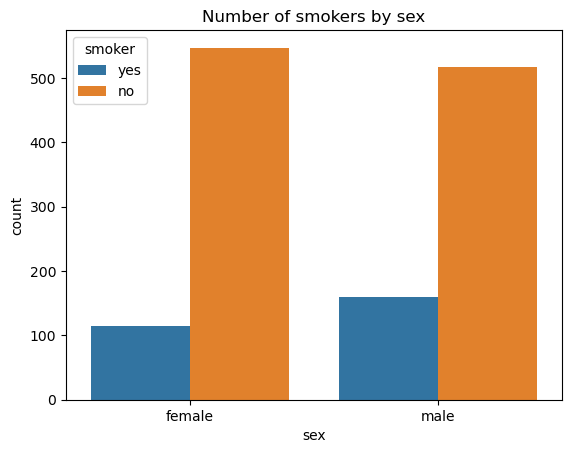

In [60]:
ax = sns.countplot(data=df, x='sex',hue='smoker',)
ax.set_title("Number of smokers by sex");


### **3. Do different regions have different charges, on average?**

In [61]:
# Investigate regions

df['region'].value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

#### Hypotheses

H<sub>0</sub>: Different regions have the same charges on average, $\mu_{northeast} = \mu_{northwest} = \mu_{southeast} = \mu_{southwest}$

H<sub>1</sub>: Different regions different charges on average

#### Test: **One-way ANOVA**

Assumptions:

- No significant outliers
- Normality
- Equal variance

In [63]:
# Create groups dictionary
groups = {}

# Loop through all unique categories
for i in df['region'].unique():
    # Get series for group and rename
    data = df.loc[df['region']==i,'charges'].copy()
    
    # save into the dictionary
    groups[i] = data
groups.keys()


dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

#### Remove outliers and test t-test assumptions

In [65]:
# Check for outliers

for i in groups.keys():
    zscores= stats.zscore(groups[i])
    outliers = abs(zscores) > 3
    print(f'{np.sum(outliers)} outliers for {i}')


8 outliers for southwest
2 outliers for southeast
7 outliers for northwest
4 outliers for northeast


In [68]:
# Remove outliers

for i in groups.keys():
    groups[i] = groups[i][(np.abs(stats.zscore(groups[i])) < 3)]


In [69]:
## Running normal test on each group and confirming there are >20 in each group
norm_results = {}
for i, data in groups.items():
    stat, p = stats.normaltest(data)
    ## save the p val, test statistic, and the size of the group
    norm_results[i] = {'n': len(data),
                             'p':p,
                             'test stat':stat,}
## convert to a dataframe
norm_results_df = pd.DataFrame(norm_results).T
norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


No group normally distributed at 0.05 level of significance, but the number of data points is high enough (n > 300 for all groups) to assume normality of sample means (central limit theorem)

In [70]:
# Test for equal variance

stats.levene(*groups.values())


LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

Unequal variances &rarr; use Welch ANOVA test instead

#### Perform Welch ANOVA test

- Same assumptions as classic one-way ANOVA apart from assumption of equal variances

In [74]:
# Install pigouin in order to access Welch's ANOVA
!pip install pingouin

     ---------------------------------------- 0.0/198.6 kB ? eta -:--:--
     -- ------------------------------------- 10.2/198.6 kB ? eta -:--:--
     ------- ----------------------------- 41.0/198.6 kB 326.8 kB/s eta 0:00:01
     ----------------------------- -------- 153.6/198.6 kB 1.0 MB/s eta 0:00:01
     -------------------------------------- 198.6/198.6 kB 1.2 MB/s eta 0:00:00
  Obtaining dependency information for pandas-flavor>=0.2.0 from https://files.pythonhosted.org/packages/67/1a/bfb5574b215f530c7ac5be684f33d60b299abbebd763c203aa31755f2fb2/pandas_flavor-0.6.0-py3-none-any.whl.metadata
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7034 sha256=2a7f7304f4d4d49e69b154b08926db047df2997879cb5d9a5df85590db703192
  Stored in directory: c:\users\javwyk\appdata\local\pip\cache\wheels\17\8d\65\9a39917567093c895549811c172be5d2dfb63c7e4b143e05a4
Succ

In [75]:
import pingouin as pg 

In [76]:
# Welch ANOVA test
result = pg.welch_anova(dv='charges', between='region', data=df) 
result


,Source,ddof1,ddof2,F,p-unc,np2
0,region,3,740.95703,2.608068,0.050593,0.006634


#### Interpretation

The p-value of $0.050593$ is higher than the set rejection threshold ($\alpha$) of $0.05$<br>
Fail to reject the null hypotheses and conclude, with 95% confidence, that regions have the same charges on average

#### Visualisation

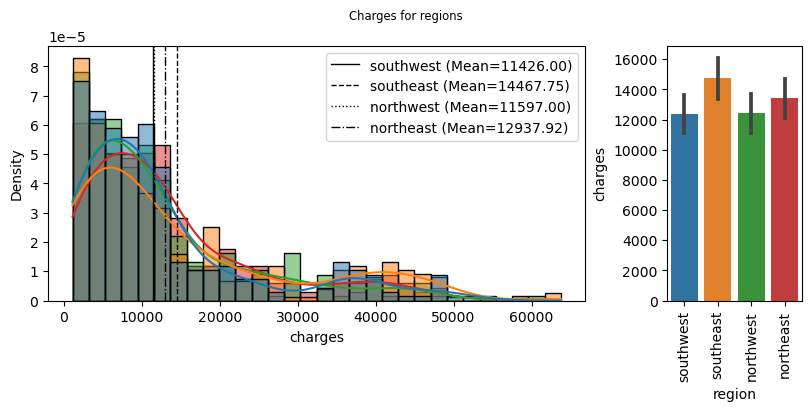

In [88]:
## Visualizing means
fig, (ax,ax_bar) = plt.subplots(figsize= (8,4), ncols=2,
                                constrained_layout=True,
                                gridspec_kw={'width_ratios':[0.8,0.2]})


# Histogram
ax = sns.histplot(data=df, x='charges',fill=True,hue='region',kde=True,
                  stat='density',common_norm=False,ax=ax)

linestyles = ['-', '--', ':', '-.']
l = 0

for i in groups.keys():
    ax.axvline(np.mean(groups[i]), ls=linestyles[l],lw=1,
           label=f"{i} (Mean={np.mean(groups[i]):.2f})",color='black')
    l = l + 1 

    
ax.legend(prop={"size":10}, loc='upper right')#bbox_to_anchor=[1,1])
## Barplot
sns.barplot(data=df, x='region',y='charges',ax = ax_bar)
fig.suptitle('Charges for regions',fontsize='small')
ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=90);